In [2]:
import yfinance as yf
import pandas as pd

# the biggest 10 stocks by market cap in 2000
# 1	Microsoft	United States	Software industry	Increase586,197
# 2	General Electric	United States	Conglomerate	Increase474,956
# 3	NTT Docomo	Japan	Telecommunications	Increase366,204
# 4	Cisco Systems	United States	Networking hardware	Increase348,965
# 5	Walmart	United States	Retail	Increase286,153
# 6	Intel	United States	Computer hardware	Increase277,096
# 7	Nippon Telegraph & Telephone	Japan	Telecommunications	Increase274,905
# 8	ExxonMobil	United States	Oil and gas	Increase265,894
# 9	Lucent	United States	Telecommunications	Increase237,668
# 10	Deutsche Telekom	Germany	Telecommunications	Increase209,628
STOCKS = ["MSFT", "GE", "CSCO", "WMT", "INTC", "NTTYY", "XOM", "DTEGY"]

data = yf.download(STOCKS, start="2000-01-01", end="2022-12-31")
data.head()


[*********************100%***********************]  8 of 8 completed


Adj Close                                                          \
                 CSCO      DTEGY          GE       INTC       MSFT      NTTYY   
Date                                                                            
1999-12-31  39.495262  25.053951  367.217102  25.547915  36.991508  19.749964   
2000-01-03  39.840889  25.296556  355.945557  27.002798  36.932102  19.878946   
2000-01-04  37.605755  23.642464  341.707642  25.741907  35.684532  19.491976   
2000-01-05  37.490547  23.907118  341.114441  25.955301  36.060772  18.847025   
2000-01-06  36.868385  22.253027  345.674896  24.442190  34.852810  18.288065   

                                     Close           ...     Open            \
                  WMT        XOM      CSCO    DTEGY  ...      WMT       XOM   
Date                                                 ...                      
1999-12-31  46.227749  20.025557  53.56250  71.0000  ...  68.3125  40.28125   
2000-01-03  44.681236  19.466265  54.03125  71.6875  ...  68.3750  39.75000   
2000-01-04  43.009354  19.093410  51.00000  67.0000  ...  65.5000  38.68750   
2000-01-05  42.131618  20.134300  50.84375  67.7500  ...  63.8750  39.00000   
2000-01-06  42.591370  21.175198  50.00000  63.0625  ...  63.0000  40.31250   

              Volume                                                        \
                CSCO   DTEGY       GE      INTC      MSFT   NTTYY      WMT   
Date                                                                         
1999-12-31  10726400   33900   764907  11572000  12517600  125400  2112700   
2000-01-03  53076000  218100  2869074  57710200  53228400  232600  8369900   
2000-01-04  50805600  134800  2875782  51019600  54119000  214800  6745100   
2000-01-05  68524000  388900  3548064  52389000  64059600  250000  7018700   
2000-01-06  48242600  134100  2583516  55171200  54976600  167800  6544500   

                      
                 XOM  
Date                  
1999-12-31   2758600  
2000-01-03  13458200  
2000-01-04  14510800  
2000-01-05  17485000  
2000-01-06  19461600  

[5 rows x 48 columns]

In [29]:
closes = data["Adj Close"]
closes.head()
closes.tail()

,AVCT,BLFY,COGT,CPAQU,HLBZ,MARA,RETO,RILYG
Date,,,,,,,,
2022-09-20,0.213,11.75,15.85,10.11,0.437,10.26,0.461,22.389999
2022-09-21,0.216,11.68,14.93,10.11,0.452,10.85,0.473,22.230000
2022-09-22,0.312,11.55,14.89,10.11,0.460,10.52,0.439,22.410000
2022-09-23,0.338,11.59,14.02,10.11,0.433,9.47,0.415,22.320000
2022-09-26,0.309,11.51,14.39,10.11,0.440,9.61,0.417,22.100000


# check what would have happened with equal weights

[***************************125%*****************************]  10 of 8 completed

<AxesSubplot:xlabel='Date'>

[************************************162%**************************************]  13 of 8 completed

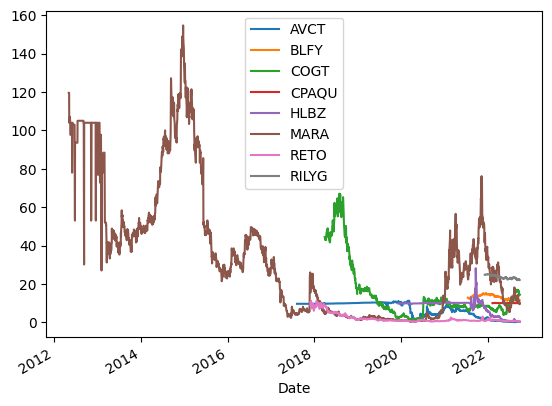

In [30]:
closes.plot()

In [31]:
startMoney = 10000
nrStocks = startMoney / closes.iloc[0]
win = nrStocks * closes.iloc[-1]
totalWin = win.sum()
print("total win is: ", totalWin)
win

total win is:  803.5116872310534


AVCT            NaN
BLFY            NaN
COGT            NaN
CPAQU           NaN
HLBZ            NaN
MARA     803.511687
RETO            NaN
RILYG           NaN
dtype: float64

In [3]:
# pyportfolio opt
import pandas as pd
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# Calculate expected returns and sample covariance

def getWeights(closes: pd.DataFrame):
    mu = expected_returns.mean_historical_return(closes)
    S = risk_models.sample_cov(closes)

    # Optimize for maximal Sharpe ratio
    
    try:
        ef = EfficientFrontier(mu, S)
        weights = ef.max_sharpe()
    except Exception:
        ef = EfficientFrontier(mu, S)
        weights = ef.min_volatility()
    return weights
# ef.portfolio_performance(verbose=True)

In [33]:
# optimize every year
from datetime import datetime


bestWin = -9999
bestLookback = -1

for lookback in [1,2,3,4,5,6,7,8,10,15,20]:
    startMoney = 10000
    money = startMoney
    stocks = dict()
    for x in STOCKS:
        stocks[x] = 0.

    portfolioTotalWorth = []
    for year in range(2000, 2022):
        start = datetime(year - lookback, 1, 1)
        end = datetime(year, 12, 31)
        subcloses = closes[start:end]
        subcloses = subcloses.fillna(method="bfill")
        if len(subcloses) == 0:
            print("skipping year", year)
            continue # wtf?!
        
        weights = getWeights(subcloses)
        # first "sell"
        for stock in STOCKS:
            # "sell"
            crntPrice = subcloses[stock][-1]
            money += crntPrice * stocks[stock]
            stocks[stock] = 0.
        # add this to total portfolio worth
        portfolioTotalWorth.append(money)
        # print(year, money)
        
        # then buy according to new weights
        for stock in STOCKS:
            crntPrice = subcloses[stock][-1]
            moneyPerStock = money * weights[stock]
            howMany = moneyPerStock / crntPrice
            money -= howMany * crntPrice
            stocks[stock] = howMany
    # endmoney
    endMoney = portfolioTotalWorth[-1]
    if endMoney > bestWin:
        bestWin = endMoney
        bestLookback = lookback
print("best lookback %d with a win of: %.2f $. better than baseline? %s" % (bestLookback, bestWin, str(bestWin > 174000)))
# 174 k is baseline
        
    
    

skipping year 2000
skipping year 2001
skipping year 2002
skipping year 2003
skipping year 2004
skipping year 2005
skipping year 2006
skipping year 2007
skipping year 2008
skipping year 2009
skipping year 2010
skipping year 2011
[***************************************************225%*****************************************************]  18 of 8 completed

ValueError: P must be symmetric/Hermitian.

[******************************************************238%********************************************************]  19 of 8 completed

[*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************2088%*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

[*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************2138%*****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

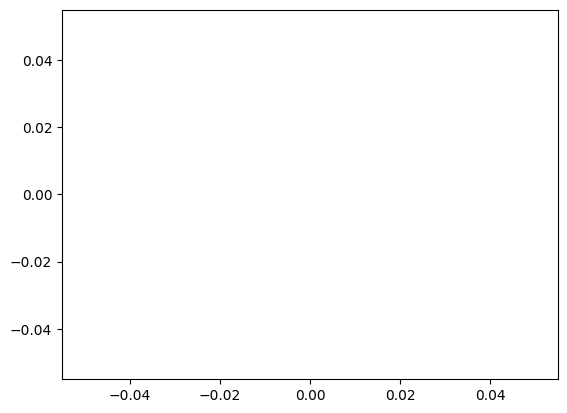

[********************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************2150%**************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

[***************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [34]:
import matplotlib.pyplot as plt

plt.plot(portfolioTotalWorth)

## try to make a better nasdaq

In [4]:
nasdaq = pd.read_csv("nasdaq_screen.csv")
# nasdaq.head()

In [5]:
nasdaq = nasdaq.sort_values(by="Market Cap", ascending=False)
nasdaq.head(20)

,Symbol,Name,Last Sale,Net Change,% Change,Market Cap,Country,IPO Year,Volume,Sector,Industry
20,AAPL,Apple Inc. Common Stock,$150.77,0.34,0.226%,2.613951e+12,United States,1980.0,93228013,Technology,Computer Manufacturing
5098,MSFT,Microsoft Corporation Common Stock,$237.45,-0.47,-0.198%,1.770876e+12,United States,1986.0,27649412,Technology,Computer Software: Prepackaged Software
3393,GOOG,Alphabet Inc. Class C Capital Stock,$98.81,-0.36,-0.363%,1.288878e+12,United States,2004.0,22415614,Technology,Internet and Information Services
3394,GOOGL,Alphabet Inc. Class A Common Stock,$98.17,-0.57,-0.577%,1.280529e+12,United States,2004.0,27021929,Technology,Internet and Information Services
476,AMZN,Amazon.com Inc. Common Stock,$115.15,1.37,1.204%,1.171869e+12,United States,1997.0,62653572,Consumer Discretionary,Catalog/Specialty Distribution
7685,TSLA,Tesla Inc. Common Stock,$276.01,0.68,0.247%,8.648691e+11,United States,2010.0,57917544,Consumer Discretionary,Auto Manufacturing
1228,BRK/A,Berkshire Hathaway Inc.,$399127.75,-5357.50,-1.325%,5.870666e+11,United States,NaN,3437,NaN,NaN
1229,BRK/B,Berkshire Hathaway Inc.,$264.32,-3.45,-1.288%,5.831722e+11,United States,NaN,4929322,NaN,NaN
7818,UNH,UnitedHealth Group Incorporated Common Stock (DE),$508.36,-5.25,-1.022%,4.755112e+11,United States,NaN,2865457,Health Care,Medical Specialities
4205,JNJ,Johnson & Johnson Common Stock,$165.70,-1.02,-0.612%,4.356551e+11,United States,NaN,8734982,Health Care,Biotechnology: Pharmaceutical Preparations


In [6]:
baseline = yf.download("NQ=F", start="2015-01-01", end="2022-12-31")
baselineWin = baseline["Adj Close"][-1] * 10000 / baseline["Adj Close"][0]
print("you would have won %.2f $ with the nasdaq" % baselineWin)
baseline.head()

[*********************100%***********************]  1 of 1 completed
you would have won 31361.71 $ with the nasdaq


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-09-18,3721.0,3785.5,3602.0,3653.5,3653.5,72994
2000-09-19,3658.5,3817.0,3656.0,3804.0,3804.0,70029
2000-09-20,3801.5,3874.0,3715.5,3853.0,3853.0,78832
2000-09-21,3852.0,3874.0,3744.0,3765.0,3765.0,70719
2000-09-22,3673.0,3780.0,3615.0,3776.0,3776.0,55926


In [160]:
nasstocks = nasdaq.sort_values(by="Market Cap", ascending=False).head(200)["Symbol"].unique().tolist()
for stock in nasstocks:
    if type(stock) != str:
        nasstocks.remove(stock)
# nasstocks # grabs the 200 biggest stocks according to marketcap
with open("nasdaq200.csv", "w") as f:
    for stock in nasstocks:
        f.write(stock+",")

In [161]:
### create closes
# nasclose = yf.download(nasstocks, start="2015-01-01", end="2022-12-31")["Adj Close"]
# nasclose.to_parquet("nasclose.parquet")
nasclose = pd.read_parquet("nasclose.parquet")
nasclose.head()

,AAPL,ABB,ABBV,ABNB,ABT,ACN,ADBE,ADI,ADP,AEP,...,USB,V,VALE,VRTX,VZ,WFC,WM,WMT,XOM,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,24.880695,15.932871,47.133759,NaN,38.892284,78.498009,72.699997,46.915043,70.450645,46.477936,...,36.075794,62.214287,5.356020,118.800003,32.941845,43.810692,43.512444,72.508408,64.462532,40.870190
2015-01-02,24.644014,15.880135,47.457870,NaN,38.788628,78.084892,72.339996,46.931938,70.383049,46.807079,...,35.979488,62.883415,5.198875,123.070000,33.068592,43.714787,43.877022,72.525291,64.727493,41.136150
2015-01-05,23.949755,15.352806,46.564751,NaN,38.797260,76.766479,71.980003,46.078480,70.332344,46.118172,...,35.112701,61.495369,5.061373,121.029999,32.793961,42.516033,43.436131,72.314201,62.956436,40.889172
2015-01-06,23.952009,15.141876,46.334267,NaN,38.356674,76.212769,70.529999,44.996861,69.749268,46.370770,...,34.647213,61.099098,5.329829,117.360001,33.124935,41.628948,43.470047,72.871429,62.621750,40.490265
2015-01-07,24.287872,15.104209,48.206940,NaN,38.667675,77.812447,71.110001,45.470070,70.357704,47.029057,...,34.952175,61.917694,5.460783,120.660004,32.911167,41.876690,43.503956,74.804893,63.256252,41.326103


In [162]:
from pprint import pprint
from pypfopt.efficient_frontier import EfficientCDaR, EfficientCVaR
nasclose = nasclose.fillna(method="ffill")
nasclose = nasclose.fillna(method="bfill")
nasclose = nasclose.dropna(axis=1, how="all")
# print(nasclose.describe())
assert not nasclose.isnull().values.any()
assert len(nasclose) > 0
# print("something nan`", nasclose.isnull().values.any())
# print(nasclose.describe())
mu = expected_returns.mean_historical_return(nasclose)
S = risk_models.sample_cov(nasclose)
S = S.fillna(0.)
assert not mu.isnull().values.any()
assert not S.isnull().values.any()


# Optimize for maximal Sharpe ratio
ef = EfficientFrontier(mu, S)
efcvar = EfficientCVaR(mu, S)
efcdar = EfficientCDaR(mu, S)
weights = dict(ef.max_sharpe())
# weights = dict(efcdar.min_cdar())
pprint(weights)

{'AAPL': 0.0,
 'ABB': 0.0,
 'ABBV': 0.0,
 'ABNB': 0.0,
 'ABT': 0.0,
 'ACN': 0.0,
 'ADBE': 0.0,
 'ADI': 0.0,
 'ADP': 0.0,
 'AEP': 0.0,
 'AMAT': 0.0,
 'AMD': 0.0347631056870226,
 'AMGN': 0.0,
 'AMOV': 0.0,
 'AMT': 0.0,
 'AMX': 0.0,
 'AMZN': 0.024781006912476,
 'AON': 0.0,
 'APD': 0.0,
 'ASML': 0.0,
 'ATVI': 0.0,
 'AVGO': 0.0,
 'AXP': 0.0,
 'AZN': 0.0,
 'BA': 0.0,
 'BABA': 0.0,
 'BAC': 0.0,
 'BAM': 0.0,
 'BDX': 0.0,
 'BHP': 0.0,
 'BKNG': 0.0,
 'BLK': 0.0,
 'BMO': 0.0,
 'BMY': 0.0,
 'BNS': 0.0,
 'BP': 0.0,
 'BSX': 0.0,
 'BTI': 0.0,
 'BUD': 0.0,
 'BX': 0.0,
 'C': 0.0,
 'CAT': 0.0,
 'CB': 0.0,
 'CCI': 0.0,
 'CHTR': 0.0,
 'CI': 0.0,
 'CL': 0.0,
 'CMCSA': 0.0,
 'CME': 0.0,
 'CNI': 0.0,
 'CNQ': 0.0,
 'COP': 0.0,
 'COST': 0.0,
 'CP': 0.0,
 'CRM': 0.0,
 'CSCO': 0.0,
 'CSX': 0.0,
 'CVS': 0.0,
 'CVX': 0.0,
 'D': 0.0,
 'DE': 0.0,
 'DEO': 0.0,
 'DG': 0.0141003881751059,
 'DHR': 0.0,
 'DIS': 0.0,
 'DUK': 0.0,
 'EL': 0.0,
 'ELV': 0.0,
 'ENB': 0.0,
 'EOG': 0.0,
 'EPD': 0.0,
 'EQIX': 0.0,
 'EQNR': 0.0,
 

In [168]:
## simulate with that
portfolio = dict()
weightsclean = dict()
for stock, weight in weights.items():
    if weight > 0.:
        portfolio[stock] = 10000 * weight
        weightsclean[stock] = weight
print(portfolio)
print(weightsclean)

{'AMD': 347.631056870226, 'AMZN': 247.81006912476, 'DG': 141.003881751059, 'KDP': 1485.450605381366, 'LLY': 1388.033974239308, 'NOC': 67.772276784775, 'NVDA': 1187.985480312478, 'PGR': 2717.5659934476557, 'TEAM': 448.23506007358895, 'TSLA': 664.717694746977, 'UNH': 354.36330165354804, 'WM': 949.430605614265}
{'AMD': 0.0347631056870226, 'AMZN': 0.024781006912476, 'DG': 0.0141003881751059, 'KDP': 0.1485450605381366, 'LLY': 0.1388033974239308, 'NOC': 0.0067772276784775, 'NVDA': 0.1187985480312478, 'PGR': 0.2717565993447656, 'TEAM': 0.0448235060073589, 'TSLA': 0.0664717694746977, 'UNH': 0.0354363301653548, 'WM': 0.0949430605614265}


In [167]:
portfolio.keys()

dict_keys(['AMD', 'AMZN', 'DG', 'KDP', 'LLY', 'NOC', 'NVDA', 'PGR', 'TEAM', 'TSLA', 'UNH', 'WM'])

In [164]:
stocksStart = dict()
portfolioEnd = dict()
for stock, investmoney in portfolio.items():
    stocksStart[stock] = investmoney / nasclose[stock][0]

# then get how much it's worth at the end
for stock, nrheld in stocksStart.items():
    portfolioEnd[stock] = nrheld * nasclose[stock][-1]
    
print("you would have won %.2f $" % sum(portfolioEnd.values()))
pprint(portfolioEnd)

you would have won 92151.54 $
{'AMD': 8632.187068463734,
 'AMZN': 1838.9128389329587,
 'DG': 514.2984357386164,
 'KDP': 5651.578034082126,
 'LLY': 7343.653532634674,
 'NOC': 247.42187594619216,
 'NVDA': 30157.329864588894,
 'PGR': 15221.731234642626,
 'TEAM': 4559.404355042872,
 'TSLA': 12373.683915132406,
 'UNH': 2006.2768746395136,
 'WM': 3605.058991123244}


In [165]:
# get pct win
wins = dict()
for stock, win in portfolioEnd.items():
    # print("stock %s won %.2f $" % (stock, win))
    # print("stock %s won %.2f %%" % (stock, (win - portfolio[stock]) / portfolio[stock] * 100.))
    wins[stock] = {"win": win, "pct": (win - portfolio[stock]) / portfolio[stock] * 100.}
wins = {k: v for k, v in sorted(wins.items(), key=lambda item: item[1]["pct"])}
pprint(wins)

{'AMD': {'pct': 2383.146110759089, 'win': 8632.187068463734},
 'AMZN': {'pct': 642.0654235026898, 'win': 1838.9128389329587},
 'DG': {'pct': 264.7406222806017, 'win': 514.2984357386164},
 'KDP': {'pct': 280.4621987165418, 'win': 5651.578034082126},
 'LLY': {'pct': 429.0687165391076, 'win': 7343.653532634674},
 'NOC': {'pct': 265.07829998382954, 'win': 247.42187594619216},
 'NVDA': {'pct': 2438.52680561858, 'win': 30157.329864588894},
 'PGR': {'pct': 460.12370155292854, 'win': 15221.731234642626},
 'TEAM': {'pct': 917.1904790969122, 'win': 4559.404355042872},
 'TSLA': {'pct': 1761.494588291713, 'win': 12373.683915132406},
 'UNH': {'pct': 466.16383956174997, 'win': 2006.2768746395136},
 'WM': {'pct': 279.70747622895874, 'win': 3605.058991123244}}


In [166]:
# totalwin with sharpe was 92151; + 131% a year
# min_volatility (lame as fuck); +24% a year
# max_quadratic_utility (only 3 stocks); + 348% a year
# efcvar.min_cvar(), a lot of stocks; +173% a year
# efcdar.min_cdar, lotta stocks, +44% a year
sum(portfolioEnd.values()) / 10000 / 7

1.3164505288709694

## manually buy the sharpe ratio

{'AMD': 0.0347631056870226, 'AMZN': 0.024781006912476, 'DG': 0.0141003881751059, 'KDP': 0.1485450605381366, 'LLY': 0.1388033974239308, 'NOC': 0.0067772276784775, 'NVDA': 0.1187985480312478, 'PGR': 0.2717565993447656, 'TEAM': 0.0448235060073589, 'TSLA': 0.0664717694746977, 'UNH': 0.0354363301653548, 'WM': 0.0949430605614265}

In [2]:
toBuy = {'AMD': 0.0347631056870226, 'AMZN': 0.024781006912476, 'DG': 0.0141003881751059, 'KDP': 0.1485450605381366, 'LLY': 0.1388033974239308, 'NOC': 0.0067772276784775, 'NVDA': 0.1187985480312478, 'PGR': 0.2717565993447656, 'TEAM': 0.0448235060073589, 'TSLA': 0.0664717694746977, 'UNH': 0.0354363301653548, 'WM': 0.0949430605614265}
from basebot import BaseBot

DUMBNESSPROTECTION = False
assert DUMBNESSPROTECTION == False

class SharpeNSDAQ(BaseBot):
    def __init__(self, name: str, backendurl: str = "http://127.0.0.1:8000"):
        super().__init__(name, backendurl)
        
sharpy = SharpeNSDAQ("sharpe-manual-0922")
money = sharpy.getPortfolio()["USD"]
for stock, weight in toBuy.items():
    try:
        crntPrice = sharpy.getCurrentPrice(stock)
        print("current price of %s is %.2f $" % (stock, crntPrice))
        sharpy.buy(stock, money * weight / crntPrice * 0.99)
    except Exception as e:
        print(stock)
        print(e)
portfol = sharpy.getPortfolio()
print("portfolio is: ")
portfol

current price of AMD is 66.30 $
current price of AMZN is 115.15 $
current price of DG is 238.46 $
current price of KDP is 37.28 $
current price of LLY is 307.50 $
current price of NOC is 474.37 $
current price of NVDA is 122.28 $
current price of PGR is 118.88 $
current price of TEAM is 213.61 $
current price of TSLA is 276.01 $
current price of UNH is 508.36 $
current price of WM is 165.22 $
WM
('Error buying: ', '{"detail":"Not enough money"}')
portfolio is: 


{'USD': 944.9053209170667,
 'AMD': 5.243303783845139,
 'AMZN': 2.1520630989229033,
 'DG': 0.5913103991490376,
 'KDP': 39.845779346063125,
 'LLY': 4.513931623542465,
 'NOC': 0.14286796695063453,
 'NVDA': 9.715288617696771,
 'PGR': 22.85974138823865,
 'TEAM': 2.0983805008793555,
 'TSLA': 2.4083101019105237,
 'UNH': 0.6970715867978551}